# Elo Merchant Category Recommendation
Ridge regression prediction with LynxKite of the [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest. The contents of the shared files can be read here:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and prediction
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

### Visualizing the data

In [1]:
import os
import gc
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")
print("{:,} observations and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))
print("{:,} observations and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

201,917 observations and 6 features in train set.
123,623 observations and 5 features in test set.


In [3]:
df_train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056


In [4]:
df_train.target.describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

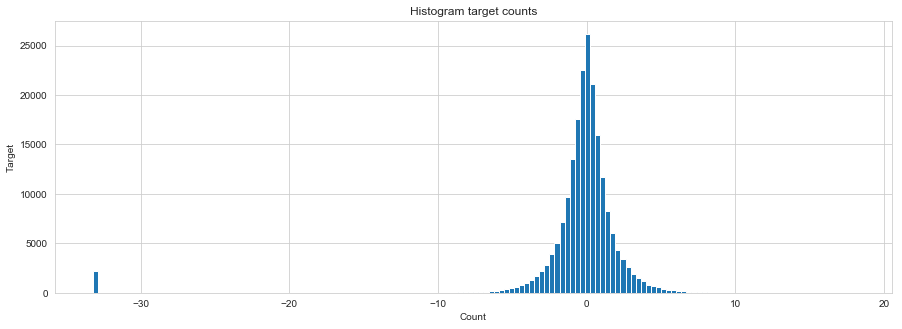

In [28]:
plt.figure(figsize=(15, 5))
plt.hist(df_train.target.values, bins=150) # normal distribution
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

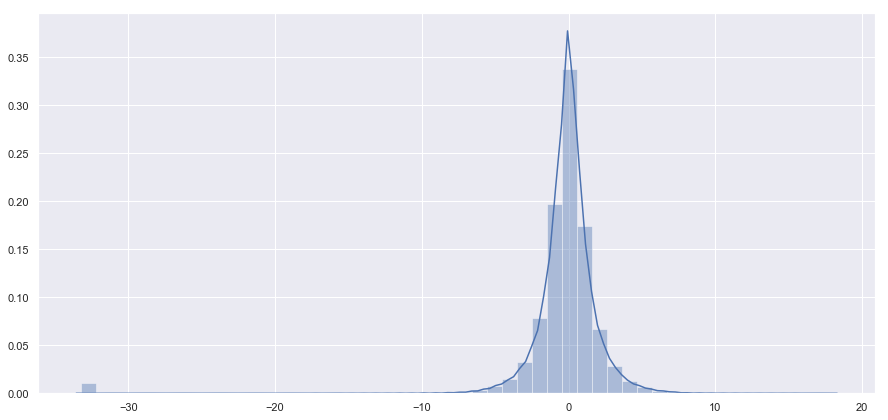

In [31]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.distplot(df_train.target.values);

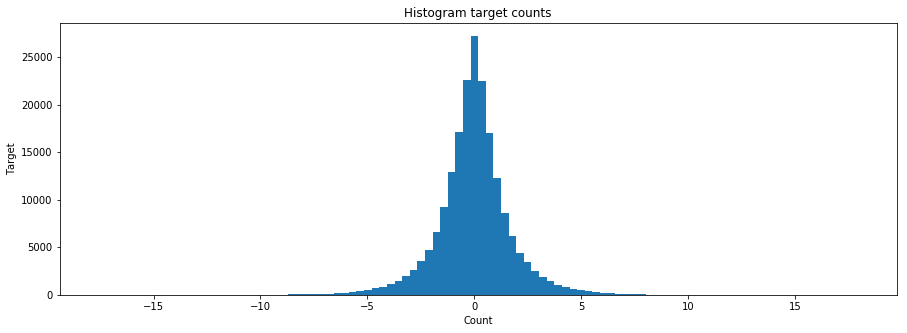

In [6]:
plt.figure(figsize=(15, 5))
plt.hist(df_train[df_train['target'] > -20].target.values, bins=100) # normal distribution
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

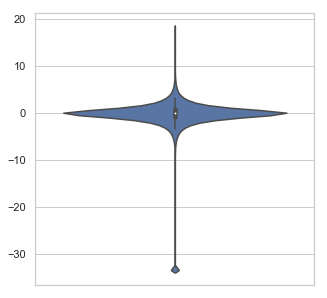

In [43]:
sns.set(rc={'figure.figsize': (5, 5)})
sns.set_style("whitegrid")
ax = sns.violinplot(x=df_train.target.values, orient='v', scale='width')
plt.show()

In [8]:
df_merch = pd.read_csv("input/merchants.csv")
df_nm_trans = pd.read_csv("input/new_merchant_transactions.csv")
print("{:,} observations and {} features in merchant set.".format(df_merch.shape[0], df_merch.shape[1]))
print("{:,} observations and {} features in new merchant set.".format(df_nm_trans.shape[0], df_nm_trans.shape[1]))

334,696 observations and 22 features in merchant set.
1,963,031 observations and 14 features in new merchant set.


In [9]:
df_merch[:3]

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0


In [10]:
df_nm_trans[:3]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14


First we'll get rid of the unnecessary category features

In [11]:
dropping = ['merchant_category_id', 'subsector_id', 'category_1', 'city_id', 'state_id', 'category_2']
for var in dropping:
    df_merch = df_merch.drop(var, axis = 1)

In [12]:
data = pd.merge(df_merch, df_nm_trans, on = 'merchant_id')
data = pd.merge(data, df_train, on = 'card_id')

In [13]:
data['purchase_time'] = data['purchase_date'].str.split(' ')
data['purchase_date'] = data['purchase_time'].str[0]
data['purchase_time'] = data['purchase_time'].str[1]

In [14]:
def get_weekday(date_string):
    date = datetime.datetime.strptime(date_string, '%Y-%m-%d')
    return calendar.day_name[date.weekday()]

data['purchase_weekday'] = data['purchase_date'].apply(lambda x: get_weekday(x))

day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['purchase_weekday'] = pd.Categorical(data['purchase_weekday'], categories = day_labels, ordered = True)

In [15]:
data[:5]

,merchant_id,merchant_group_id,numerical_1,numerical_2,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,...,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target,purchase_time,purchase_weekday
0,M_ID_c9eb20f6f5,25449,-0.057471,-0.057471,E,E,NaN,1.666667,3,NaN,...,1.0,16,18,2013-11,3,3,1,-0.242904,11:45:08,Wednesday
1,M_ID_063592fa97,62376,-0.057471,-0.057471,E,E,2.38,2.284722,3,2.31,...,1.0,16,21,2013-11,3,3,1,-0.242904,15:40:28,Monday
2,M_ID_7f86c618d3,99247,-0.057471,-0.057471,D,C,0.98,0.953118,3,0.91,...,1.0,16,37,2013-11,3,3,1,-0.242904,20:43:36,Friday
3,M_ID_0812f3d71e,68950,-0.057471,-0.057471,D,D,0.90,0.978395,3,0.85,...,1.0,16,21,2013-11,3,3,1,-0.242904,14:01:49,Monday
4,M_ID_88859fc8e2,15120,-0.047556,-0.047556,D,E,1.00,0.945578,3,0.88,...,1.0,16,10,2013-11,3,3,1,-0.242904,07:55:33,Saturday


[Aggregation and representing uncertainty](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty)
The default behavior in seaborn is to aggregate the multiple measurements at each x value by plotting the mean and the 95% confidence interval around the mean.

Text(0.5,0,'Purchase Weekday')

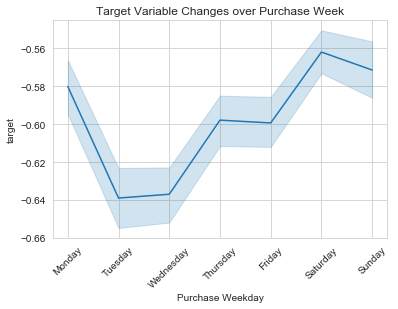

In [16]:
ax = sns.lineplot(x = "purchase_weekday", y = "target", markers = False, dashes = True, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over Purchase Week')
ax.set_xlabel('Purchase Weekday')

In [17]:
def get_month(date_string, kind = 'month'):
    if kind == 'month':
        date = datetime.datetime.strptime(date_string, '%Y-%m')
    elif kind == 'day':
        date = datetime.datetime.strptime(date_string, '%Y-%m-%d')
    return date.strftime("%B")

data['purchase_month'] = data['purchase_date'].apply(lambda x: get_month(x, kind='day'))
data['first_active_month2'] = data['first_active_month'].apply(lambda x: get_month(x))

month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
data['purchase_month'] = pd.Categorical(data['purchase_month'], categories = month_labels, ordered = True)
data['first_active_month2'] = pd.Categorical(data['first_active_month2'], categories = month_labels, ordered = True)

Text(0.5,0,'Purchase Month')

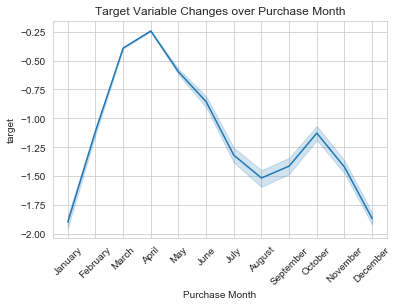

In [18]:
ax = sns.lineplot(x = "purchase_month", y = "target", markers = True, dashes = False, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over Purchase Month')
ax.set_xlabel('Purchase Month')

Text(0.5,0,'First Active Month')

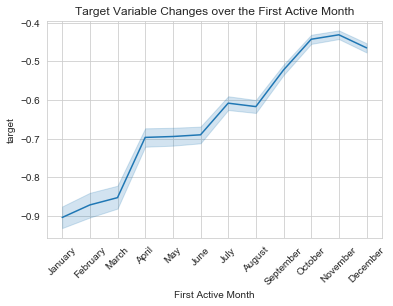

In [19]:
ax = sns.lineplot(x = "first_active_month2", y = "target", markers = True, dashes = False, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over the First Active Month')
ax.set_xlabel('First Active Month')

In [22]:
data['temp'] = data['purchase_time'].str.split(':')

def get_session(time_list):
    time_list[0] = int(time_list[0])
    if time_list[0] > 4 and time_list[0] < 12:
        return 'Morning'
    elif time_list[0] >= 12 and time_list[0] < 17:
        return 'Afternoon'
    elif time_list[0] >= 17 and time_list[0] < 21:
        return 'Evening'
    else:
        return 'Night'
    
data['purchase_session'] = data['temp'].apply(lambda x: get_session(x))

session_labels = ['Morning', 'Afternoon', 'Evening', 'Night']
data['purchase_session'] = pd.Categorical(data['purchase_session'], categories = session_labels, ordered = True)
data.drop('temp', axis = 1, inplace=True)

Text(0.5,0,'Purchase Time of Day')

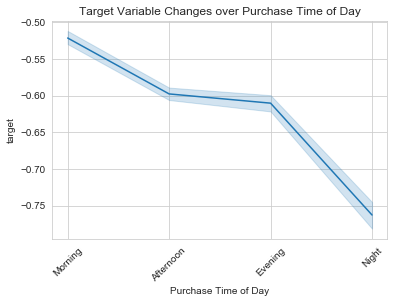

In [24]:
ax = sns.lineplot(x = "purchase_session", y = "target", markers = True, dashes = False, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over Purchase Time of Day')
ax.set_xlabel('Purchase Time of Day')

In [25]:
data['first_active_year'] = data['first_active_month'].str[:4]

year_labels = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
data['first_active_year'] = pd.Categorical(data['first_active_year'], categories = year_labels, ordered = True)

Text(0.5,0,'First Active Year')

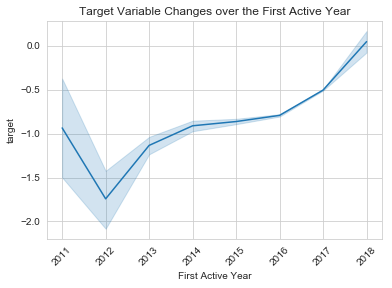

In [26]:
ax = sns.lineplot(x = "first_active_year", y = "target", markers = True, dashes = False, data = data)
plt.xticks(rotation = 45)
ax.set_title('Target Variable Changes over the First Active Year')
ax.set_xlabel('First Active Year')

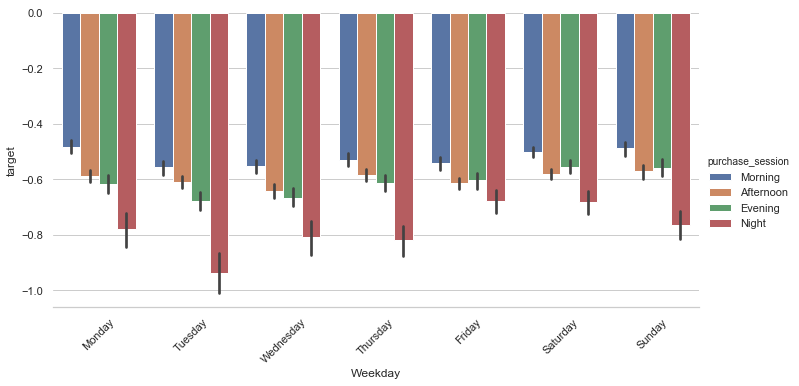

In [44]:
ax = sns.catplot(x='purchase_weekday', y='target', hue='purchase_session', data=data, kind='bar', height=5, aspect=2)
ax.despine(left = True)
plt.xticks(rotation = 45)
ax.set_ylabels("target")
ax.set_xlabels('Weekday')

In [45]:
def get_time_of_month_cat(date):
    date_temp = date.split('-')
    if int(date_temp[2]) < 10:
        time_of_month = 'Beginning'
    elif int(date_temp[2]) >= 10 and int(date_temp[2]) < 20:
        time_of_month = 'Middle'
    else:
        time_of_month = 'End'
    return time_of_month

data['time_of_month_cat'] = data['purchase_date'].apply(lambda x: get_time_of_month_cat(x))

tof_labels = ['Beginning', 'Middle', 'End']
data['time_of_month_cat'] = pd.Categorical(data['time_of_month_cat'], categories=tof_labels, ordered=True)
#data['time_of_month_num'] = data['purchase_date'].str[8:].astype(int)

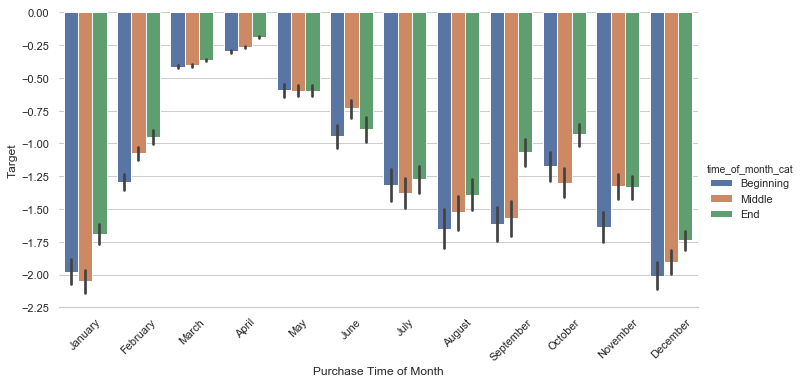

In [46]:
ax = sns.catplot(x='purchase_month', y='target', hue='time_of_month_cat', data=data, kind='bar', height=5, aspect=2)
ax.despine(left = True)
plt.xticks(rotation = 45)
ax.set_ylabels("Target")
ax.set_xlabels('Purchase Time of Month')

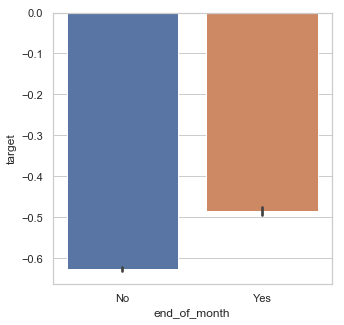

In [47]:
def get_end_of_month(date):
    date_temp = date.split('-')
    if int(date_temp[2]) >= 25:
        end_of_month = 'Yes'
    else:
        end_of_month = 'No'
    return end_of_month

data['end_of_month'] = data['purchase_date'].apply(lambda x: get_end_of_month(x))

ax = sns.barplot(x = 'end_of_month', y = 'target', data = data)